O objetivo é criar um portfólio que otimiza o risco-retorno dos investimentos disponíveis escolhendo os pesos ideais pra cada ativo na carteira

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
from scipy.optimize import minimize
import matplotlib.ticker as mtick
import yfinance as yf

In [12]:
inicio = dt.date(2015, 1, 1)
final = dt.date(2022, 12, 31)

In [18]:
lista_acoes = ['WEGE3', 'LREN3', 'VALE3', 'PETR4', 'EQTL3', 'EGIE3']
lista_acoes = [acao + '.SA' for acao in lista_acoes]
#lista_acoes = ["AAPL", "NKE", "GOOGL", "AMZN"]

precos = yf.download(lista_acoes, inicio, final)['Adj Close']

precos

[*********************100%***********************]  6 of 6 completed


,EGIE3.SA,EQTL3.SA,LREN3.SA,PETR4.SA,VALE3.SA,WEGE3.SA
Date,,,,,,
2015-01-02,15.295002,4.655889,10.702309,4.124554,13.109158,5.124121
2015-01-05,15.313766,4.478119,10.404793,3.772028,12.912025,5.159060
2015-01-06,15.623319,4.730382,10.524646,3.648643,13.429493,5.082531
2015-01-07,16.017303,4.689750,10.703721,3.820501,13.922318,5.024303
2015-01-08,16.181467,4.655889,10.716412,4.067268,14.070166,5.109149
...,...,...,...,...,...,...
2022-12-23,38.090000,26.969999,21.653334,25.120001,84.465065,38.228981
2022-12-26,37.759998,26.309999,20.495455,24.940001,85.238083,37.921162
2022-12-27,37.560001,26.370001,20.168873,25.110001,87.273392,37.742432


In [19]:
retornos = precos.pct_change().apply(lambda x: np.log(1 + x)).dropna() #retorno logaritmo
media_retornos = retornos.mean()
matriz_covar = retornos.cov()
media_retornos

EGIE3.SA    0.000456
EQTL3.SA    0.000885
LREN3.SA    0.000321
PETR4.SA    0.000897
VALE3.SA    0.000952
WEGE3.SA    0.001012
dtype: float64

In [22]:
numero_carteiras = 100000
tabela_retornos_esperados = np.zeros(numero_carteiras)
tabela_volatilidades_esperadas = np.zeros(numero_carteiras)
tabela_sharpe = np.zeros(numero_carteiras)
tabela_pesos = np.zeros((numero_carteiras, len(lista_acoes)))

for i in range(numero_carteiras):
    
    pesos = np.random.random(len(lista_acoes))
    pesos = pesos / np.sum(pesos)
    tabela_pesos[i, :] = pesos
    
    tabela_retornos_esperados[i] = np.sum(media_retornos * pesos * 252)
    tabela_volatilidades_esperadas[i] = np.sqrt(np.dot(pesos.T, np.dot(matriz_covar * 252, pesos)))
    
    tabela_sharpe[i] = tabela_retornos_esperados[i] / tabela_volatilidades_esperadas[i]

In [23]:
indice_sharpe_max = tabela_sharpe.argmax()
tabela_pesos[indice_sharpe_max]

array([0.02634071, 0.50801386, 0.00411257, 0.02315022, 0.14738685,
       0.2909958 ])

In [25]:
tabela_retornos_esperados_arit = np.exp(tabela_retornos_esperados) - 1

In [27]:
eixo_y_fronteiira_eficiente = np.linspace(tabela_retornos_esperados_arit.min(), tabela_retornos_esperados_arit.max(), 50)


def pegando_retorno(peso_teste):
    peso_teste = np.array(peso_teste)
    retorno = np.sum(media_retornos * peso_teste) * 252
    retorno = np.exp(retorno) - 1
    
    return retorno



def checando_soma_pesos(peso_teste):
    
    return np.sum(peso_teste) - 1



def pegando_vol(peso_teste):
    peso_teste = np.array(peso_teste)
    vol = np.sqrt(np.dot(peso_teste.T, np.dot(matriz_covar * 252, peso_teste)))
    
    return vol



peso_inicial = [1 / len(lista_acoes)] * len(lista_acoes)
limites = tuple([(0, 1) for ativo in lista_acoes])

eixo_x_fronteira_eficiente = []

for retorno_possivel in eixo_y_fronteiira_eficiente:
    #pegar melhor volatilidade para cada retorno possível
    restricoes = ({'type' : 'eq', 'fun' : checando_soma_pesos},
                   {'type' : 'eq', 'fun' : lambda w: pegando_retorno(w) - retorno_possivel})
    
    result = minimize(pegando_vol, peso_inicial, method = 'SLSQP', bounds = limites, constraints = restricoes)
    eixo_x_fronteira_eficiente.append(result['fun'])

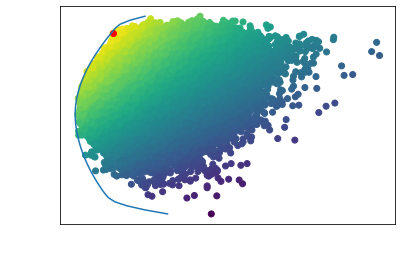

In [32]:
fig, ax = plt.subplots()

ax.scatter(tabela_volatilidades_esperadas, tabela_retornos_esperados_arit, c = tabela_sharpe)
plt.xlabel('Volatilidade esperada')
plt.ylabel('Retorno esperado')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.scatter(tabela_volatilidades_esperadas[indice_sharpe_max], tabela_retornos_esperados_arit[indice_sharpe_max], c = 'r')
ax.plot(eixo_x_fronteira_eficiente, eixo_y_fronteiira_eficiente)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.tick_params(axis = 'x', colors = 'white')
ax.tick_params(axis = 'y', colors = 'white')

plt.show()